In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 2.6201 - val_loss: 0.4221
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.3808 - val_loss: 0.3401
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2591 - val_loss: 0.3504
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2157 - val_loss: 0.3775
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1827 - val_loss: 0.3933
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.1553 - val_loss: 0.3982
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1241 - val_loss: 0.4137
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1158 - val_loss: 0.4113
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1028 - val_loss: 0.4232
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.0912 - val_loss: 0.4392
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.0857 - val_loss: 0.4123
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.0736 - val_loss: 0.4615
Epoch 12: early stopping
Epoch 1/1000
136/136 - 3s - 21ms/step - loss: 2.9649 - val_loss: 0.5413
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.

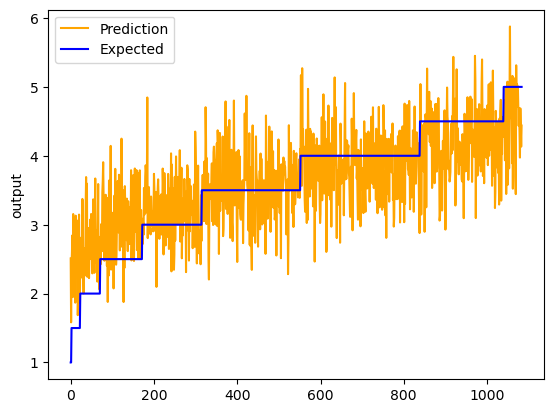

In [2]:
# Author: Nicolas Gugliemo, Katrina Yu
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 
# (1) Report the RMSE and plot the lift chart of the BEST neural network model you have obtained.
# (2) Choose 5 arbitrary businesses from your test data (preferably from different categories). Show
#     the names, the true star ratings, and the predicted ratings (from your best model) of those
#     businesses.
# Type: Regression (Expect a number)
# Data Restrictions:
# (1) Businesses with at least 20 reviews
# (2) At least 10K businesses in set
# (3) Business = busisness_id, stars, review_count, categories
# (4) Review   = busisness_id, stars, text 
'''Grading:  (5 pts) Do train/test split.
 (5 pts) Remove all the businesses with less than 20 reviews.
 (10 pts) Use TF-IDF to do feature extraction from review texts.
 (10 pts) Use EarlyStopping when using Tensorflow.
 (30 pts) Change the following hyperparameters to record how they affect performance in your report.
Tabulate your findings.
o Activation: relu, sigmoid, tanh
o Layers and neuron counts
o Optimizer: adam and sgd
 (10 pts) Report the RMSE of the BEST regression model you obtained
 (10 pts) Plot the lift chart on test data of the BEST regression model you obtained
 (5 pts) Show names and the true ratings of 5 businesses, and their predicted ratings
 (5 pts) Your report includes the following sections:
o Problem Statement
o Methodology
o Experimental Results and Analysis
o Task Division and Project Reflection
 (10 pts) Additional features
'''
import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i<10):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
print(pred)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 10 businesses
for j in range(10):
    #j = random.randint(0, (pred.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y[j], pred[j]))

print("{}. {} {}: rating: {}, predicted rating: {}".format(101+1, businesses[101], b_id[101], y[101], pred[101]))
j=1000
print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y[j], pred[j]))
# Plot the chart
chart_regression(pred.flatten(),y_test)

In [3]:
''' 
Tuning the following hyperparameters when training neural networks using Tensorflow and
tabulate all the results of each model on how they affect performance in your report. Also,
save all the models you have tried as a proof in your notebook.
• Activation: relu, sigmoid, tanh
• Number of layers and neuron count for each layer
• Optimizer: adam and sgd. 
'''

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50, 25], [150, 75, 30], [100, 100, 100]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart
pred = best_model.predict(x_test)
chart_regression(pred.flatten(), y_test)

plot(results_df)

REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 52ms/step - loss: 2.6549 - val_loss: 0.4884
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.5404 - val_loss: 0.3928
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.3986 - val_loss: 0.3621
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.3370 - val_loss: 0.3665
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.2931 - val_loss: 0.3759
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.2671 - val_loss: 0.3864
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.2398 - val_loss: 0.4005
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.2241 - val_loss: 0.3972
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.2091 - val_loss: 0.3937
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.1933 - val_loss: 0.3891
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.1835 - val_loss: 0.3887
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1822 - val_loss: 0.3944
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.1688 - val_loss: 0.3807
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[3.0027

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 1.6441 - val_loss: 0.6597
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7768 - val_loss: 0.6058
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.7366 - val_loss: 0.5832
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.6753 - val_loss: 0.5390
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.6172 - val_loss: 0.4866
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.5460 - val_loss: 0.4275
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.4859 - val_loss: 0.3842
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.4387 - val_loss: 0.3547
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.4248 - val_loss: 0.3354
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3887 - val_loss: 0.3414
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.3851 - val_loss: 0.3170
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3671 - val_loss: 0.3376
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.3539 - val_loss: 0.3069
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.3350 - val_loss: 0.3697


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 54ms/step - loss: 2.5207 - val_loss: 0.4300
Epoch 2/1000
136/136 - 1s - 11ms/step - loss: 0.5164 - val_loss: 0.3428
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.3952 - val_loss: 0.3901
Epoch 4/1000
136/136 - 2s - 11ms/step - loss: 0.3344 - val_loss: 0.3729
Epoch 5/1000
136/136 - 2s - 12ms/step - loss: 0.2884 - val_loss: 0.3821
Epoch 6/1000
136/136 - 1s - 10ms/step - loss: 0.2664 - val_loss: 0.3940
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.2522 - val_loss: 0.4259
Epoch 8/1000
136/136 - 58s - 427ms/step - loss: 0.2377 - val_loss: 0.4095
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2072 - val_loss: 0.4096
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1949 - val_loss: 0.4022
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.1922 - val_loss: 0.4020
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.1923 - val_loss: 0.4353
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2.8711617]
 [3.2241058]
 [2.6046784]
 ...
 [4.6697173]
 [3.5290415]
 

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 12ms/step - loss: 1.6968 - val_loss: 0.6272
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.7745 - val_loss: 0.6078
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.7180 - val_loss: 0.5746
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.6828 - val_loss: 0.5490
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.5915 - val_loss: 0.4676
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.5118 - val_loss: 0.3970
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.4438 - val_loss: 0.3593
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.4060 - val_loss: 0.3347
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.3859 - val_loss: 0.3208
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3572 - val_loss: 0.3252
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3408 - val_loss: 0.3079
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.3324 - val_loss: 0.3079
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.3078 - val_loss: 0.2988
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.2967 - val_loss: 0.3256
Epoch 15/100

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 24ms/step - loss: 2.2302 - val_loss: 0.3642
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.3690 - val_loss: 0.3426
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2654 - val_loss: 0.3537
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2132 - val_loss: 0.3735
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.1763 - val_loss: 0.3855
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.1554 - val_loss: 0.3919
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1423 - val_loss: 0.4175
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1270 - val_loss: 0.4002
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1197 - val_loss: 0.4038
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1134 - val_loss: 0.4016
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1114 - val_loss: 0.4027
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.1021 - val_loss: 0.4105
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[2.9014864]
 [3.5570867]
 [2.364595 ]
 ...
 [4.637193 ]
 [3.812455 ]
 [4.1219106]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 13ms/step - loss: 1.4358 - val_loss: 0.6227
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.7084 - val_loss: 0.6026
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.6602 - val_loss: 0.5509
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.5899 - val_loss: 0.4941
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.5307 - val_loss: 0.4220
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.4490 - val_loss: 0.3686
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3960 - val_loss: 0.3344
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3666 - val_loss: 0.3214
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3449 - val_loss: 0.3211
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3351 - val_loss: 0.3263
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3191 - val_loss: 0.3719
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3050 - val_loss: 0.3057
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2934 - val_loss: 0.3175
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2776 - val_loss: 0.3220
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 25ms/step - loss: 2.9184 - val_loss: 0.6596
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.8165 - val_loss: 0.6438
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.8194 - val_loss: 0.6464
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.7969 - val_loss: 0.6402
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.7888 - val_loss: 0.6323
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.7767 - val_loss: 0.6144
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.7456 - val_loss: 0.5546
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.6144 - val_loss: 0.3894
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.4465 - val_loss: 0.3198
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3862 - val_loss: 0.3029
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3561 - val_loss: 0.3062
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3210 - val_loss: 0.2930
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.3183 - val_loss: 0.3073
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2981 - val_loss: 0.2925
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 22ms/step - loss: 0.9896 - val_loss: 0.6655
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7703 - val_loss: 0.6462
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.7676 - val_loss: 0.6458
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.7684 - val_loss: 0.6461
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.7503 - val_loss: 0.6461
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.7530 - val_loss: 0.6463
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.7332 - val_loss: 0.6526
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7519 - val_loss: 0.6463
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.7410 - val_loss: 0.6505
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.7418 - val_loss: 0.6501
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.7353 - val_loss: 0.6466
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.7341 - val_loss: 0.6529
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[3.6195636]
 [3.6204152]
 [3.6202555]
 ...
 [3.6205535]
 [3.6218584]
 [3.62082

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 59ms/step - loss: 1.4126 - val_loss: 0.6431
Epoch 2/1000
136/136 - 1s - 11ms/step - loss: 0.8087 - val_loss: 0.6368
Epoch 3/1000
136/136 - 1s - 11ms/step - loss: 0.7806 - val_loss: 0.6034
Epoch 4/1000
136/136 - 2s - 12ms/step - loss: 0.6879 - val_loss: 0.4638
Epoch 5/1000
136/136 - 1s - 11ms/step - loss: 0.4792 - val_loss: 0.3236
Epoch 6/1000
136/136 - 2s - 12ms/step - loss: 0.3785 - val_loss: 0.2973
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.3355 - val_loss: 0.3144
Epoch 8/1000
136/136 - 2s - 11ms/step - loss: 0.3219 - val_loss: 0.2850
Epoch 9/1000
136/136 - 1s - 10ms/step - loss: 0.3014 - val_loss: 0.2859
Epoch 10/1000
136/136 - 1s - 11ms/step - loss: 0.2793 - val_loss: 0.2859
Epoch 11/1000
136/136 - 1s - 11ms/step - loss: 0.2764 - val_loss: 0.2862
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.2594 - val_loss: 0.2902
Epoch 13/1000
136/136 - 1s - 10ms/step - loss: 0.2504 - val_loss: 0.3023
Epoch 14/1000
136/136 - 1s - 10ms/step - loss: 0.2393 - val_

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 23ms/step - loss: 1.1002 - val_loss: 0.6509
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7972 - val_loss: 0.6622
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.7848 - val_loss: 0.6512
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.7811 - val_loss: 0.6481
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.7629 - val_loss: 0.6464
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.7595 - val_loss: 0.6491
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.7473 - val_loss: 0.6503
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7355 - val_loss: 0.6491
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.7316 - val_loss: 0.6480
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.7350 - val_loss: 0.6456
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.7317 - val_loss: 0.6468
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.7425 - val_loss: 0.6458
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.7324 - val_loss: 0.6459
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.7256 - val_loss: 0.6459


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 52ms/step - loss: 1.0822 - val_loss: 0.6420
Epoch 2/1000


PermissionError: [Errno 13] Permission denied: 'model_sigmoid_[100, 100, 100]_adam.keras'